In [10]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets

import matplotlib.pyplot as plt
import time
import copy
import dlc_practical_prologue as prologue
from BaseNet import *
from ConvNet1 import *

########################################################
### FRAMEWORK FOR INPUT AS TWO SINGLE CHANNEL IMAGES ###

# In this framework, the network is first trained to recognize the digits of each image from each pair and with the help of the class labels. To do so, we use the class labels provided and use a CrossEntropyLoss to maximize the response of the correct digit. Once the network can predict the digits, we compare the digits together.

nb_classes = 10
nb_input_channels = 1

mini_batch_size = 1000
nb_epochs = 300
eta = 0.001

def prep_input_vanilla(train_input):
    new_train_input = train_input.view(-1,1,14,14)
    return new_train_input

# One-hot encoding for train_classes
def prep_target_vanilla(train_classes): 
    y = train_classes.flatten().view(-1, 1)
    train_onehot = torch.FloatTensor(len(y), nb_classes)
    return train_onehot.scatter_(1, y, 1)


# Computes the number of errors when predicting with the model passed as parameter and comparing results with the target classes; this corresponds to the task of our network, ie predicting the right digit.
def compute_nb_errors(model, input_, target, mini_batch_size=mini_batch_size):
    nb_errors = 0  
    for b in range(0, input_.size(0), mini_batch_size):
        output = model(input_.narrow(0, b, mini_batch_size))
        _, target_classes = torch.max(target.narrow(0, b, mini_batch_size), 1)
        _, predicted_classes = torch.max(output, 1)
        nb_errors += (predicted_classes != target_classes).sum().item()      
    return nb_errors

# input = 1000x2x14x14: Gets a 2 channels input tensor, predicts a digit for each image of each channel using the model passed as parameter, then compares the pairs channel-wise
# output = 1000: 1 if the val_a < val_b, 0 otherwise
def compare_pairs(model, input_):
    tensor_a = torch.max(model(input_[:,0,:,:].view(-1,1,14,14)), 1)[1]
    tensor_b = torch.max(model(input_[:,1,:,:].view(-1,1,14,14)),1)[1]
    return torch.le(tensor_a, tensor_b)


# Network is a classifier: it treats the pairs as 2 images of 1 channel and is trained to predict the digit from the image
def train_model_1C(model, train_input, train_classes, optimizer, mini_batch_size=mini_batch_size,
                   criterion=torch.nn.CrossEntropyLoss(), nb_epochs=nb_epochs):
    train_input = prep_input_vanilla(train_input)
    train_target = train_classes.flatten() # the target are the class labels 
    nb_samples = len(train_input)
    
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for e in range(0, nb_epochs):
        
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for b in range(0, train_input.size(0), mini_batch_size):
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(train_input.narrow(0, b, mini_batch_size))
                    target = train_target.narrow(0, b, mini_batch_size)
                    
                    # the nn.CrossEntropyLoss expects a class index as the target for each value
                    loss = criterion(output, target)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * train_input.size(0)
                running_corrects += torch.sum(torch.max(output, 1)[1] == target)       

            epoch_loss = running_loss / nb_samples
            epoch_acc = running_corrects.double() / nb_samples
            
            if (e % 100 == 99):
                print('phase: %s, epoch: %d, loss: %.5f, acc: %.4f' %
                      (phase, e+1, epoch_loss, epoch_acc))
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    time_elapsed = time.time() - since
    print('Training complete in %.0f min %.0f s' % (time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: %.4f' % (best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
            
def test_model_1C(model, test_input, test_target, test_classes):
    model.eval()
    print("Model in training mode? ", model.training)
    test_input_vanilla = prep_input_vanilla(test_input)
    test_classes_target = prep_target_vanilla(test_classes)
    
    # Number of digits incorrectly identified
    nb_errors_digits = compute_nb_errors(model, test_input_vanilla, test_classes_target)
    print("nb_errors_digits = ", nb_errors_digits)
    
    # Number of pairs incorrectly identified
    test_output_pairs = compare_pairs(model, test_input).type(torch.LongTensor)
    nb_errors_pairs = torch.abs(test_output_pairs-test_target).sum().item()
    print("nb_errors_pairs = ", nb_errors_pairs)
    

In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

#model = BaseNet1C(nb_classes)
model = ConvNet1_1C(nb_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.95)
model, val_acc_history = train_model_1C(model, train_input, train_classes, optimizer)


phase: train, epoch: 100, loss: 1.44493, acc: 0.7915
phase: val, epoch: 100, loss: 1.42741, acc: 0.7945
phase: train, epoch: 200, loss: 0.27240, acc: 0.9605
phase: val, epoch: 200, loss: 0.26991, acc: 0.9610
phase: train, epoch: 300, loss: 0.09784, acc: 0.9925
phase: val, epoch: 300, loss: 0.09711, acc: 0.9925
Training complete in 3 min 22 s
Best val acc: 0.9925


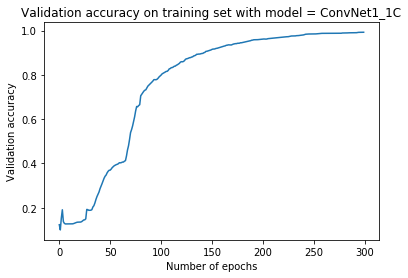

In [3]:
def plot_val_accuracy(model, val_acc_history):
    plt.plot(val_acc_history)
    plt.xlabel('Number of epochs')
    plt.ylabel('Validation accuracy')
    plt.title('Validation accuracy on training set with model = ' + model.name)
    plt.show()
    
plot_val_accuracy(model, val_acc_history)

In [11]:
test_model_1C(model, test_input, test_target, test_classes)

Model in training mode?  False
nb_errors_digits =  1142
nb_errors_pairs =  85


In [5]:
# Computes the number of errors between target and classes
def compute_nb_errors_data(set_, target, classes): 
    is_pair = torch.le(classes[:,0], classes[:,1]).type(torch.LongTensor)
    nb_errors = torch.abs(target-is_pair).sum().item()
    print('There are %d errors in the %s dataset' % (nb_errors, set_))
    
compute_nb_errors_data('training', train_target, train_classes)
compute_nb_errors_data('test', test_target, test_classes)

There are 0 errors in the training dataset
There are 0 errors in the test dataset
